In [1]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<ipython-input-1-b07882b7b3a0>:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import importlib, pkg_resources


<module 'pkg_resources' from '/lustre/work/client/users/ejlaird/.conda/envs/quantum/lib/python3.9/site-packages/pkg_resources/__init__.py'>

In [ ]:
!pip install tensorflow-probability==0.15.0

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq

import gym, cirq, sympy
import numpy as np
from functools import reduce
from collections import deque, defaultdict
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
tf.get_logger().setLevel('ERROR')

In [3]:
def one_qubit_rotation(qubit, symbols):
    """
    Returns Cirq gates that apply a rotation of the bloch sphere about the X,
    Y and Z axis, specified by the values in `symbols`.
    """
    return [cirq.rx(symbols[0])(qubit),
            cirq.ry(symbols[1])(qubit),
            cirq.rz(symbols[2])(qubit)]

def entangling_layer(qubits):
    """
    Returns a layer of CZ entangling gates on `qubits` (arranged in a circular topology).
    """
    cz_ops = [cirq.CZ(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
    cz_ops += ([cirq.CZ(qubits[0], qubits[-1])] if len(qubits) != 2 else [])
    return cz_ops

In [4]:
def generate_circuit(qubits, n_layers):
    """Prepares a data re-uploading circuit on `qubits` with `n_layers` layers."""
    # Number of qubits
    n_qubits = len(qubits)

    # Sympy symbols for variational angles
    params = sympy.symbols(f'theta(0:{3*(n_layers+1)*n_qubits})')
    params = np.asarray(params).reshape((n_layers + 1, n_qubits, 3))

    # Sympy symbols for encoding angles
    inputs = sympy.symbols(f'x(0:{n_layers})'+f'_(0:{n_qubits})')
    inputs = np.asarray(inputs).reshape((n_layers, n_qubits))

    # Define circuit
    circuit = cirq.Circuit()
    for l in range(n_layers):
        # Variational layer
        circuit += cirq.Circuit(one_qubit_rotation(q, params[l, i]) for i, q in enumerate(qubits))
        circuit += entangling_layer(qubits)
        # Encoding layer
        circuit += cirq.Circuit(cirq.rx(inputs[l, i])(q) for i, q in enumerate(qubits))

    # Last varitional layer
    circuit += cirq.Circuit(one_qubit_rotation(q, params[n_layers, i]) for i,q in enumerate(qubits))

    return circuit, list(params.flat), list(inputs.flat)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

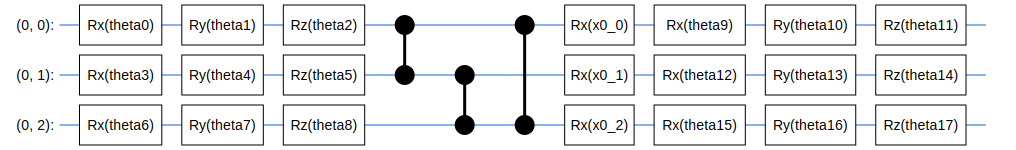

In [5]:
n_qubits, n_layers = 3, 1
qubits = cirq.GridQubit.rect(1, n_qubits)
circuit, _, _ = generate_circuit(qubits, n_layers)
SVGCircuit(circuit)

In [149]:
class ReUploadingPQC(tf.keras.layers.Layer):
    """
    Performs the transformation (s_1, ..., s_d) -> (theta_1, ..., theta_N, lmbd[1][1]s_1, ..., lmbd[1][M]s_1,
        ......., lmbd[d][1]s_d, ..., lmbd[d][M]s_d) for d=input_dim, N=theta_dim and M=n_layers.
    An activation function from tf.keras.activations, specified by `activation` ('linear' by default) is
        then applied to all lmbd[i][j]s_i.
    All angles are finally permuted to follow the alphabetical order of their symbol names, as processed
        by the ControlledPQC.
    """

    def __init__(self, qubits, n_layers, observables, activation="linear", name="re-uploading_PQC"):
        super(ReUploadingPQC, self).__init__(name=name)
        self.n_layers = n_layers
        self.n_qubits = len(qubits)

        circuit, theta_symbols, input_symbols = generate_circuit(qubits, n_layers)

        theta_init = tf.random_uniform_initializer(minval=0.0, maxval=np.pi)
        self.theta = tf.Variable(
            initial_value=theta_init(shape=(1, len(theta_symbols)), dtype="float32"),
            trainable=True, name="thetas"
        )

        lmbd_init = tf.ones(shape=(self.n_qubits * self.n_layers,))
        self.lmbd = tf.Variable(
            initial_value=lmbd_init, dtype="float32", trainable=True, name="lambdas"
        )

        self.logZ = tf.Variable(
            initial_value=0.0, dtype="float32", trainable=True, name="logZ"
        )

        # Define explicit symbol order.
        symbols = [str(symb) for symb in theta_symbols + input_symbols]
        self.indices = tf.constant([symbols.index(a) for a in sorted(symbols)])

        self.activation = activation
        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
        self.computation_layer = tfq.layers.ControlledPQC(circuit, observables)        

    def call(self, inputs):
        # inputs[0] = encoding data for the state.
        batch_dim = tf.gather(tf.shape(inputs[0]), 0)
        tiled_up_circuits = tf.repeat(self.empty_circuit, repeats=batch_dim)
        tiled_up_thetas = tf.tile(self.theta, multiples=[batch_dim, 1])
        tiled_up_inputs = tf.tile(inputs[0], multiples=[1, self.n_layers])
        scaled_inputs = tf.einsum("i,ji->ji", self.lmbd, tiled_up_inputs)
        squashed_inputs = tf.keras.layers.Activation(self.activation)(scaled_inputs)

        joined_vars = tf.concat([tiled_up_thetas, squashed_inputs], axis=1)
        joined_vars = tf.gather(joined_vars, self.indices, axis=1)

        return self.computation_layer([tiled_up_circuits, joined_vars])

In [7]:
class Alternating(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(Alternating, self).__init__()
        self.w = tf.Variable(
            initial_value=tf.constant([[(-1.)**i for i in range(output_dim)]]), dtype="float32",
            trainable=True, name="obs-weights")

    def call(self, inputs):
        return tf.matmul(inputs, self.w)

In [8]:
n_qubits = 4 # Dimension of the state vectors in CartPole
n_layers = 5 # Number of layers in the PQC
n_actions = 2 # Number of actions in CartPole

qubits = cirq.GridQubit.rect(1, n_qubits)

In [9]:
ops = [cirq.Z(q) for q in qubits]
observables = [reduce((lambda x, y: x * y), ops)] # Z_0*Z_1*Z_2*Z_3

In [10]:
def generate_model_policy(qubits, n_layers, n_actions, beta, observables):
    """Generates a Keras model for a data re-uploading PQC policy."""

    input_tensor = tf.keras.Input(shape=(len(qubits), ), dtype=tf.dtypes.float32, name='input')
    re_uploading_pqc = ReUploadingPQC(qubits, n_layers, observables)([input_tensor])
    process = tf.keras.Sequential([
        Alternating(n_actions),
        tf.keras.layers.Lambda(lambda x: x * beta),
        tf.keras.layers.Softmax()
    ], name="observables-policy")
    policy = process(re_uploading_pqc)
    model = tf.keras.Model(inputs=[input_tensor], outputs=policy)

    return model

model = generate_model_policy(qubits, n_layers, n_actions, 1.0, observables)

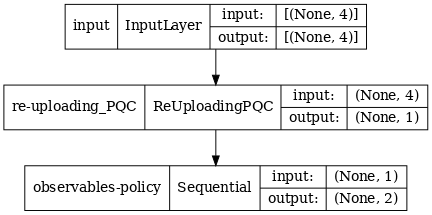

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [12]:
def gather_episodes(state_bounds, n_actions, model, n_episodes, env_name):
    """Interact with environment in batched fashion."""

    trajectories = [defaultdict(list) for _ in range(n_episodes)]
    envs = [gym.make(env_name) for _ in range(n_episodes)]

    done = [False for _ in range(n_episodes)]
    states = [e.reset()[0] for e in envs] # added [0] to get rid of the second output of reset()

    while not all(done):
        unfinished_ids = [i for i in range(n_episodes) if not done[i]]
        normalized_states = [s/state_bounds for i, s in enumerate(states) if not done[i]]

        for i, state in zip(unfinished_ids, normalized_states):
            trajectories[i]['states'].append(state)

        # Compute policy for all unfinished envs in parallel
        states = tf.convert_to_tensor(normalized_states)
        action_probs = model([states])

        # Store action and transition all environments to the next state
        states = [None for i in range(n_episodes)]
        for i, policy in zip(unfinished_ids, action_probs.numpy()):
            action = np.random.choice(n_actions, p=policy)
            states[i], reward, done[i], _, _ = envs[i].step(action) # added _ to remove last {} in env
            trajectories[i]['actions'].append(action)
            trajectories[i]['rewards'].append(reward)

    return trajectories

In [13]:
def compute_returns(rewards_history, gamma):
    """Compute discounted returns with discount factor `gamma`."""
    returns = []
    discounted_sum = 0
    for r in rewards_history[::-1]:
        discounted_sum = r + gamma * discounted_sum
        returns.insert(0, discounted_sum)

    # Normalize them for faster and more stable learning
    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    returns = returns.tolist()

    return returns

In [14]:
state_bounds = np.array([2.4, 2.5, 0.21, 2.5])
gamma = 1
batch_size = 10
n_episodes = 1000

In [15]:
optimizer_in = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.01, amsgrad=True)
optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)

# Assign the model parameters to each optimizer
w_in, w_var, w_out = 1, 0, 2

In [16]:
@tf.function
def reinforce_update(states, actions, returns, model):
    states = tf.convert_to_tensor(states)
    actions = tf.convert_to_tensor(actions)
    returns = tf.convert_to_tensor(returns)

    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        logits = model(states)
        p_actions = tf.gather_nd(logits, actions)
        log_probs = tf.math.log(p_actions)
        loss = tf.math.reduce_sum(-log_probs * returns) / batch_size
    grads = tape.gradient(loss, model.trainable_variables)
    for optimizer, w in zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]):
        optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])

In [17]:
env_name = "CartPole-v1"

# Start training the agent
episode_reward_history = []
for batch in range(n_episodes // batch_size):
    # Gather episodes
    episodes = gather_episodes(state_bounds, n_actions, model, batch_size, env_name)

    # Group states, actions and returns in numpy arrays
    states = np.concatenate([ep['states'] for ep in episodes])
    actions = np.concatenate([ep['actions'] for ep in episodes])
    rewards = [ep['rewards'] for ep in episodes]
    returns = np.concatenate([compute_returns(ep_rwds, gamma) for ep_rwds in rewards])
    returns = np.array(returns, dtype=np.float32)

    id_action_pairs = np.array([[i, a] for i, a in enumerate(actions)])

    # Update model parameters.
    reinforce_update(states, id_action_pairs, returns, model)

    # Store collected rewards
    for ep_rwds in rewards:
        episode_reward_history.append(np.sum(ep_rwds))

    avg_rewards = np.mean(episode_reward_history[-10:])

    print('Finished episode', (batch + 1) * batch_size,
          'Average rewards: ', avg_rewards)

    if avg_rewards >= 500.0:
        break

/lustre/work/client/users/ejlaird/.conda/envs/quantum/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Finished episode 10 Average rewards:  20.5
Finished episode 20 Average rewards:  16.4
Finished episode 30 Average rewards:  22.8
Finished episode 40 Average rewards:  19.8
Finished episode 50 Average rewards:  19.9
Finished episode 60 Average rewards:  23.4
Finished episode 70 Average rewards:  24.6
Finished episode 80 Average rewards:  34.6
Finished episode 90 Average rewards:  49.9
Finished episode 100 Average rewards:  65.5
Finished episode 110 Average rewards:  82.6
Finished episode 120 Average rewards:  93.7
Finished episode 130 Average rewards:  135.0
Finished episode 140 Average rewards:  156.1
Finished episode 150 Average rewards:  179.7
Finished episode 160 Average rewards:  185.8
Finished episode 170 Average rewards:  202.8
Finished episode 180 Average rewards:  184.1
Finished episode 190 Average rewards:  363.1
Finished episode 200 Average rewards:  327.3
Finished episode 210 Average rewards:  376.6
Finished episode 220 Average rewards:  426.6
Finished episode 230 Average re

# PQC-GFlowNet

## Smiley

In [210]:
class ReUploadingPQC(tf.keras.layers.Layer):
    """
    Performs the transformation (s_1, ..., s_d) -> (theta_1, ..., theta_N, lmbd[1][1]s_1, ..., lmbd[1][M]s_1,
        ......., lmbd[d][1]s_d, ..., lmbd[d][M]s_d) for d=input_dim, N=theta_dim and M=n_layers.
    An activation function from tf.keras.activations, specified by `activation` ('linear' by default) is
        then applied to all lmbd[i][j]s_i.
    All angles are finally permuted to follow the alphabetical order of their symbol names, as processed
        by the ControlledPQC.
    """

    def __init__(self, qubits, n_layers, observables, activation="linear", name="re-uploading_PQC"):
        super(ReUploadingPQC, self).__init__(name=name)
        self.n_layers = n_layers
        self.n_qubits = len(qubits)

        circuit, theta_symbols, input_symbols = generate_circuit(qubits, n_layers)

        theta_init = tf.random_uniform_initializer(minval=0.0, maxval=np.pi)
        self.theta = tf.Variable(
            initial_value=theta_init(shape=(1, len(theta_symbols)), dtype="float32"),
            trainable=True, name="thetas"
        )

        lmbd_init = tf.ones(shape=(self.n_qubits * self.n_layers,))
        self.lmbd = tf.Variable(
            initial_value=lmbd_init, dtype="float32", trainable=True, name="lambdas"
        )

        self.logZ = tf.Variable(
            initial_value=1.0, dtype="float32", trainable=True, name="logZ"
        )

        # Define explicit symbol order.
        symbols = [str(symb) for symb in theta_symbols + input_symbols]
        self.indices = tf.constant([symbols.index(a) for a in sorted(symbols)])

        self.activation = activation
        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
        self.computation_layer = tfq.layers.ControlledPQC(circuit, observables)        

    def call(self, inputs):
        # inputs[0] = encoding data for the state.
        batch_dim = tf.gather(tf.shape(inputs[0]), 0)
        tiled_up_circuits = tf.repeat(self.empty_circuit, repeats=batch_dim)
        tiled_up_thetas = tf.tile(self.theta, multiples=[batch_dim, 1])
        tiled_up_inputs = tf.tile(inputs[0], multiples=[1, self.n_layers])
        scaled_inputs = tf.einsum("i,ji->ji", self.lmbd, tiled_up_inputs)
        squashed_inputs = tf.keras.layers.Activation(self.activation)(scaled_inputs)

        joined_vars = tf.concat([tiled_up_thetas, squashed_inputs], axis=1)
        joined_vars = tf.gather(joined_vars, self.indices, axis=1)

        return self.computation_layer([tiled_up_circuits, joined_vars])

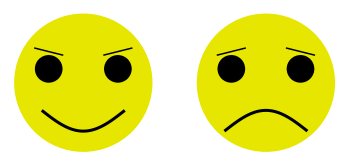

In [18]:
import matplotlib.pyplot as pp
import numpy as np
base_face = lambda: (pp.gca().add_patch(pp.Circle((0.5,0.5),0.5,fc=(.9,.9,0))),
                     pp.gca().add_patch(pp.Circle((0.25,0.6),0.1,fc=(0,0,0))),
                     pp.gca().add_patch(pp.Circle((0.75,0.6),0.1,fc=(0,0,0))))
patches = {
  'smile': lambda: pp.gca().add_patch(pp.Polygon(np.stack([np.linspace(0.2,0.8), 0.3-np.sin(np.linspace(0,3.14))*0.15]).T, closed=False, fill=False, lw=3)),
  'frown': lambda: pp.gca().add_patch(pp.Polygon(np.stack([np.linspace(0.2,0.8), 0.15+np.sin(np.linspace(0,3.14))*0.15]).T, closed=False, fill=False, lw=3)),
  'left_eb_down': lambda: pp.gca().add_line(pp.Line2D([0.15, 0.35], [0.75,0.7], color=(0,0,0))),
  'right_eb_down': lambda: pp.gca().add_line(pp.Line2D([0.65, 0.85], [0.7,0.75], color=(0,0,0))),
  'left_eb_up': lambda: pp.gca().add_line(pp.Line2D([0.15, 0.35], [0.7,0.75], color=(0,0,0))),
  'right_eb_up': lambda: pp.gca().add_line(pp.Line2D([0.65, 0.85], [0.75,0.7], color=(0,0,0))),
}
sorted_keys = sorted(patches.keys())

def draw_face(face):
  base_face()
  for i in face:
    patches[i]()
  pp.axis('scaled')
  pp.axis('off')

f, ax = pp.subplots(1,2)
pp.sca(ax[0])
draw_face(['smile', 'left_eb_down', 'right_eb_down'])
pp.sca(ax[1])
draw_face(['frown', 'left_eb_up', 'right_eb_up'])

#### Smiley Reward

In [138]:
def has_overlap(face):
  # Can't have two overlapping eyebrows!
  if 'left_eb_down' in face and 'left_eb_up' in face:
    return True
  if 'right_eb_down' in face and 'right_eb_up' in face:
    return True
  # Can't have two overlapping mouths!
  if 'smile' in face and 'frown' in face:
    return True
  return False

def face_reward(face):
  if has_overlap(face):
    return tf.constant(0.0)
  eyebrows = 'left_eb_down', 'left_eb_up', 'right_eb_down', 'right_eb_up'
  # Must have exactly two eyebrows
  if sum([i in face for i in eyebrows]) != 2:
    return tf.constant(0.0)
  # We want twice as many happy faces as sad faces so here we give a reward of 2 for smiles
  if 'smile' in face:
    return tf.constant(2.0)
  if 'frown' in face:
    return tf.constant(1.0)  # and a reward of 1 for frowns
  # If we reach this point, there's no mouth
  return tf.constant(0.0)


# We first define how the model will view a face, i.e. how to encode a face in
# a tensor
def face_to_tensor(face):
  return tf.convert_to_tensor([tf.constant([float(i in face) for i in sorted_keys], dtype=tf.float32)])

In [170]:
class ActionMasking(tf.keras.layers.Layer):
    def __init__(self, state_size):
        super(ActionMasking, self).__init__()
        self.state_size = state_size

    def call(self, logits, x):
        indices_f = tf.range(self.state_size)
        indices_b = tf.range(self.state_size, self.state_size * 2)
        
        P_f = tf.gather(logits, indices_f, axis=1) * (1 - x) + x * -100
        P_b = tf.gather(logits, indices_b, axis=1) * x + (1 - x) * -100
        
        return P_f, P_b

In [53]:
n_qubits = 6 # Dimension of the state vectors in Smiley
n_layers = 5 # Number of layers in the PQC
n_actions = 6*2 # Number of actions in Smiley

qubits = cirq.GridQubit.rect(1, n_qubits)

ops = [cirq.Z(q) for q in qubits]
observables = [reduce((lambda x, y: x * y), ops)] # Z_0*Z_1*Z_2*Z_3

In [166]:
def generate_forward_flow(qubits, n_layers, n_actions, beta, observables):
    """Generates a Keras model for a data re-uploading PQC Gflownet."""

    input_tensor = tf.keras.Input(shape=(len(qubits), ), dtype=tf.dtypes.float32, name='input')
    re_uploading_pqc = ReUploadingPQC(qubits, n_layers, observables)([input_tensor])
    alternating = Alternating(n_actions)(re_uploading_pqc)
    lmbd1 = tf.keras.layers.Lambda(lambda x: x * beta)(alternating)
    action_masking = ActionMasking(n_qubits)(lmbd1, input_tensor)

    model = tf.keras.Model(inputs=[input_tensor], outputs=action_masking)

    return model

model = generate_forward_flow(qubits, n_layers, n_actions, 1.0, observables)

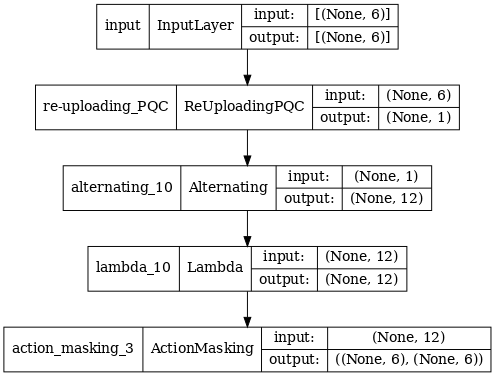

In [81]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

### PQC-Gflownet Training Loop

In [261]:
model = generate_forward_flow(qubits, n_layers, n_actions, 1.0, observables)

optimizer_in = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_logz = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)

# Assign the model parameters to each optimizer
w_in, w_var, w_out, w_logz = 1, 0, 3, 2

In [262]:
from tqdm import tqdm
import tensorflow_probability as tfp
Categorical = tfp.distributions.Categorical

NUM_EPISODES = 10000
update_freq = 2
minibatch_loss = 0.0

sampled_faces = []
losses = []
grads_list = []
logZs = []



for episode in tqdm(range(NUM_EPISODES)):
    state = []
    
    total_forward_flow = 0.0
    total_backward_flow = 0.0

    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)

        for t in range(3):

            # compute flows 
            p_f, p_b = model(face_to_tensor(state))

            cat = Categorical(logits=p_f[0])
            action = cat.sample().numpy()

            # take action
            new_state = state + [sorted_keys[action]]

            # accumulate forward flow
            total_forward_flow += cat.log_prob(action)

            if t == 2:
                reward = face_reward(new_state)

            # recompute flows for new state
            p_f, p_b = model(face_to_tensor(new_state))

            # accumulate backward flow
            total_backward_flow += Categorical(logits=p_b[0]).log_prob(action)

            # update state
            state = new_state

        # compute loss
        loss = tf.square(model.trainable_variables[w_logz] + total_forward_flow - tf.clip_by_value(tf.math.log(reward), -20, 2) - total_backward_flow)
        minibatch_loss += loss

    sampled_faces.append(state)
    if episode % update_freq == 0:
        # gradient update
        grads = tape.gradient(minibatch_loss, model.trainable_variables)
        for optimizer, w in zip([optimizer_in, optimizer_var, optimizer_out, optimizer_logz], [w_in, w_var, w_out, w_logz]):
            optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])
        
        grads_list.append(grads)
        losses.append(minibatch_loss.numpy())
        logZs.append(model.trainable_variables[w_logz].numpy())
        minibatch_loss = 0.0
            



  3%|▎         | 277/10000 [00:29<16:48,  9.64it/s]

In [260]:
tf.square(model.trainable_variables[w_logz] + total_forward_flow - tf.clip_by_value(tf.math.log(reward), -20, 2) - total_backward_flow)

<tf.Tensor: shape=(), dtype=float32, numpy=6.0820103>

In [247]:
model.trainable_variables[w_logz], total_forward_flow, reward, total_backward_flow

(<tf.Variable 'logZ:0' shape=() dtype=float32, numpy=0.3284792>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-4.6591454>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.8644929>)

In [249]:
p_f

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[-1.0000000e+02, -1.0000000e+02, -3.3166807e-02,  3.7008323e-02,
        -1.0000000e+02,  3.7935555e-02]], dtype=float32)>

In [248]:
p_b

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[-3.7475035e-02,  3.6045160e-02, -1.0000000e+02, -1.0000000e+02,
        -3.4338523e-02, -1.0000000e+02]], dtype=float32)>

In [251]:
t_f, t_b = model(face_to_tensor([]))
t_f[0]

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([ 0.0944984 , -0.09164103,  0.07827054, -0.08733615,  0.09509493,
       -0.08952434], dtype=float32)>

In [252]:
t_cat = Categorical(logits=t_f[0])


In [259]:
model.trainable_variables[w_logz]

<tf.Tensor: shape=(), dtype=float32, numpy=-1.7011625>

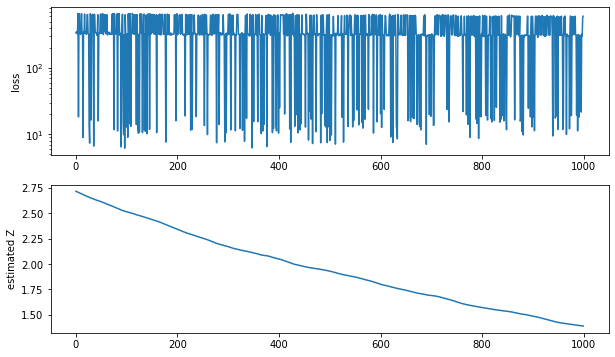

In [239]:
import numpy as np

f, ax = pp.subplots(2, 1, figsize=(10,6))
pp.sca(ax[0])
pp.plot(losses)
pp.yscale('log')
pp.ylabel('loss')
pp.sca(ax[1])
pp.plot(np.exp(logZs))
pp.ylabel('estimated Z');

In [214]:
np.exp(model.trainable_variables[w_logz].numpy())

1.9905202

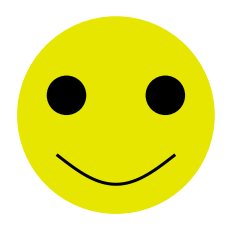

In [222]:
draw_face(['smile'])

In [230]:
cat.sample()

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [232]:
cat.logits

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([-100.       ,   -3.1776445, -100.       ,   -3.4374864,
          3.0339234,   -3.1084561], dtype=float32)>

In [223]:
p_f[0]

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([-100.       ,   -3.2030172, -100.       ,   -3.464934 ,
       -100.       ,   -3.1332767], dtype=float32)>

In [229]:
sorted_keys

['frown',
 'left_eb_down',
 'left_eb_up',
 'right_eb_down',
 'right_eb_up',
 'smile']

Ratio of faces with a smile: 0.5234375
Ratio of valid faces: 0.46875


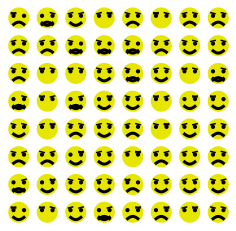

In [242]:
f, ax = pp.subplots(8,8,figsize=(4,4))
print('Ratio of faces with a smile:', sum(['smile' in i for i in sampled_faces[-128:]]) / 128)
print('Ratio of valid faces:', sum([face_reward(i).numpy() > 0 for i in sampled_faces[-128:]]) / 128)
for i, face in enumerate(sampled_faces[-64:]):
  pp.sca(ax[i//8,i%8])
  draw_face(face)

Ratio of faces with a smile: 0.5234375
Ratio of valid faces: 0.359375


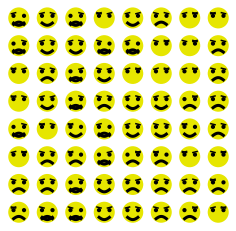

In [241]:
f, ax = pp.subplots(8,8,figsize=(4,4))
print('Ratio of faces with a smile:', sum(['smile' in i for i in sampled_faces[:128]]) / 128)
print('Ratio of valid faces:', sum([face_reward(i).numpy() > 0 for i in sampled_faces[:128]]) / 128)
for i, face in enumerate(sampled_faces[:64]):
  pp.sca(ax[i//8,i%8])
  draw_face(face)